In [1]:
# !pip install -r requirements.txt
# !pip install -q lpips scikit-image tqdm

In [2]:
import torch
import time
from typing import Optional
from image_editor import DiffusionImageEditor
from transformers import CLIPProcessor, CLIPModel
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from datasets import load_dataset

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="torchvision.models._utils"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/kmgabidullin/mmm_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
ds = load_dataset("arood0/mmm_project_with_audio_ru_final", split="train")
ds.features

{'IMAGE_ID': Value(dtype='string', id=None),
 'EDITING_TYPE': Value(dtype='string', id=None),
 'CORE': Value(dtype='int32', id=None),
 'MASK': Value(dtype='int32', id=None),
 'EDITING_INSTRUCTION': Value(dtype='string', id=None),
 'OUTPUT_DESCRIPTION': Value(dtype='string', id=None),
 'INPUT_CAPTION_BY_LLAMA': Value(dtype='string', id=None),
 'OUTPUT_CAPTION_BY_LLAMA': Value(dtype='string', id=None),
 'INPUT_IMG': Image(mode=None, decode=True, id=None),
 'MASK_IMG': Image(mode=None, decode=True, id=None),
 'OUTPUT_IMG': Image(mode=None, decode=True, id=None),
 'EDITING_INSTRUCTION_RU': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None)}

### Метрики качества редактирования

Будем сравнивать модели по следующим метрикам:
- **CLIP similarity** (text–image): насколько сгенерированное изображение соответствует инструкции
    - Эмбединги таргета/предикта и косинус расстояния между ними
- **PSNR / SSIM**: похожесть с целевым изображением `OUTPUT_IMG` (традиционные метрики качества генерации)
- **LPIPS**: перцептивное расстояние между сгенерированным и целевым изображениями

А также посмотрим на цену инференса (время/память) генерации одного примера

In [4]:
clip_device = device
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(clip_device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()


def compute_clip_similarity(image: Image.Image, text: str) -> float:
    inputs = clip_processor(
        text=[text],
        images=[image],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77,
    )
    inputs = {k: v.to(clip_device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = clip_model(**inputs)
        img_emb = outputs.image_embeds
        txt_emb = outputs.text_embeds
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
    sim = (img_emb * txt_emb).sum(dim=-1).item()
    return float(sim)


def _to_np(img: Image.Image) -> np.ndarray:
    arr = np.array(img.convert("RGB"), dtype=np.float32) / 255.0
    return arr

def compute_psnr_ssim(ref: Image.Image, pred: Image.Image) -> dict:

    if pred.size != ref.size:
        pred = pred.resize(ref.size, Image.BICUBIC)

    ref_np = _to_np(ref)
    pred_np = _to_np(pred)
    psnr_val = psnr(ref_np, pred_np, data_range=1.0)
    try:
        ssim_val = ssim(ref_np, pred_np, channel_axis=-1, data_range=1.0)
    except TypeError:
        ssim_val = ssim(ref_np, pred_np, multichannel=True, data_range=1.0)
    return {"psnr": float(psnr_val), "ssim": float(ssim_val)}


lpips_model = lpips.LPIPS(net="vgg").to(device)
lpips_model.eval()


def compute_lpips(ref: Image.Image, pred: Image.Image) -> Optional[float]:
    if pred.size != ref.size:
        pred = pred.resize(ref.size, Image.BICUBIC)

    def pil_to_tensor(img: Image.Image) -> torch.Tensor:
        arr = np.array(img.convert("RGB"), dtype=np.float32) / 255.0
        arr = arr.transpose(2, 0, 1)  # HWC -> CHW
        t = torch.from_numpy(arr)[None, ...]
        t = t * 2.0 - 1.0
        return t.to(device)

    with torch.no_grad():
        ref_t = pil_to_tensor(ref)
        pred_t = pil_to_tensor(pred)
        d = lpips_model(ref_t, pred_t)
    return float(d.item())

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/kmgabidullin/mmm_project/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


### 3. Модели для сравнения

Сравним три модели image-to-image:
1. **InstructPix2Pix** (`timbrooks/instruct-pix2pix`) — через ваш класс `ImageEditor`;
2. **Stable Diffusion img2img** (`runwayml/stable-diffusion-v1-5`);
3. **SDXL-turbo image2image** (`stabilityai/sdxl-turbo`) — быстрая, но более тяжёлая модель.

Модели будем прогонять по одному и тому же подмножеству датасета и считать описанные выше метрики.


In [5]:
MODEL_CONFIGS = [
    {
        "name": "instruct_pix2pix",
        "model_id": "timbrooks/instruct-pix2pix",
        "params": {
            "num_inference_steps": 20,
            "image_guidance_scale": 1.5,
            "guidance_scale": 7.5,
        },
    },
    {
        "name": "sd_img2img",
        "model_id": "runwayml/stable-diffusion-v1-5",
        "params": {
            "num_inference_steps": 30,
            "strength": 0.75,
            "guidance_scale": 7.5,
        },
    },
    {
        "name": "sdxl_turbo",
        "model_id": "stabilityai/sdxl-turbo",
        "params": {
            "num_inference_steps": 4,
            "strength": 0.6,
            "guidance_scale": 0.0,
        },
    },
]

def load_model(config):
    params = config["params"]

    editor = DiffusionImageEditor(
        model_type=config["name"],
        model_name=config.get("model_id"),
        device=device,
        num_inference_steps=params.get("num_inference_steps", 20),
        strength=params.get("strength", 0.75),
        image_guidance_scale=params.get("image_guidance_scale", 1.5),
        guidance_scale=params.get("guidance_scale", 7.5),
    )
    return editor

### 4. Подвыборка датасета для оценки

Чтобы не тратить слишком много времени и памяти, возьмём небольшую подвыборку
датасета (по умолчанию 32 примера). При желании вы сможете увеличить размер.


In [6]:
import random
MAX_SAMPLES = 32
RANDOM_SEED = 52

rng = random.Random(RANDOM_SEED)
indices = list(range(len(ds)))
rng.shuffle(indices)
indices = indices[:MAX_SAMPLES]

subset = [ds[i] for i in indices]
print(f"Используем {len(subset)} примеров из {len(ds)}.")

Используем 32 примеров из 2000.


In [7]:
from tqdm.auto import tqdm

results = []

for cfg in MODEL_CONFIGS:
    model_name = cfg["name"]
    print(f"{'-' * 20}\nМодель: {model_name}")

    model = load_model(cfg)
    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()
    model_times = []

    for idx, sample in enumerate(tqdm(subset, desc=model_name)):

        src_img, tgt_img, instr = sample["INPUT_IMG"], sample["OUTPUT_IMG"], sample["EDITING_INSTRUCTION_RU"]
        start = time.time()
        try:
            gen_img = model.edit(src_img, instr)
        except Exception as e:
            print(f"Ошибка генерации (модель {model_name}, пример {idx}): {e}")
            continue
        elapsed = time.time() - start
        model_times.append(elapsed)

        clip_score = compute_clip_similarity(gen_img, instr)
        psnr_ssim = compute_psnr_ssim(tgt_img, gen_img)
        lpips_val = compute_lpips(tgt_img, gen_img)

        results.append(
            {
                "model_name": model_name,
                "sample_index": idx,
                "clip_similarity": clip_score,
                "psnr": psnr_ssim["psnr"],
                "ssim": psnr_ssim["ssim"],
                "lpips": lpips_val,
                "time_sec": elapsed,
            }
        )
    model.close()

df_results = pd.DataFrame(results)
df_results.head()


--------------------
Модель: instruct_pix2pix
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Модель загружена: timbrooks/instruct-pix2pix


instruct_pix2pix: 100%|██████████| 32/32 [05:33<00:00, 10.42s/it]


--------------------
Модель: sd_img2img
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


sd_img2img: 100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


--------------------
Модель: sdxl_turbo
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Модель загружена: stabilityai/sdxl-turbo


sdxl_turbo: 100%|██████████| 32/32 [00:49<00:00,  1.56s/it]


model_name  sample_index  clip_similarity       psnr      ssim  \
0  instruct_pix2pix             0         0.215216  19.191715  0.590165   
1  instruct_pix2pix             1         0.190771  14.362189  0.496617   
2  instruct_pix2pix             2         0.210804  20.089475  0.602093   
3  instruct_pix2pix             3         0.209751  15.465506  0.616951   
4  instruct_pix2pix             4         0.227863  16.655964  0.759352   

      lpips   time_sec  
0  0.308321   5.569676  
1  0.639918  13.408873  
2  0.238615  13.236439  
3  0.334409  13.247499  
4  0.288002  13.340163

### Сравним модели по метрикам


In [9]:
agg = (
    df_results
    .groupby(["model_name"], as_index=False)
    .agg(
        clip_similarity_mean=("clip_similarity", "mean"),
        psnr_mean=("psnr", "mean"),
        ssim_mean=("ssim", "mean"),
        lpips_mean=("lpips", "mean"),
        time_sec_mean=("time_sec", "mean"),
    )
    .sort_values("clip_similarity_mean", ascending=False)
)
display(agg)

model_name  clip_similarity_mean  psnr_mean  ssim_mean  lpips_mean  \
1        sd_img2img              0.219423  16.106905   0.479940    0.601408   
2        sdxl_turbo              0.208386  16.816902   0.572258    0.536161   
0  instruct_pix2pix              0.200394  20.039832   0.739220    0.299988   

   time_sec_mean  
1       7.896710  
2       1.102381  
0       9.957242

### 7. Визуальное сравнение для нескольких примеров

Построим визуализацию для 3 примеров: исходное изображение, результаты всех моделей
и целевое изображение `OUTPUT_IMG`.


--------------------
Пример 0
Инструкция: Сократить количество роз.
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Модель загружена: timbrooks/instruct-pix2pix


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.43it/s]


Модель загружена: stabilityai/sdxl-turbo


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


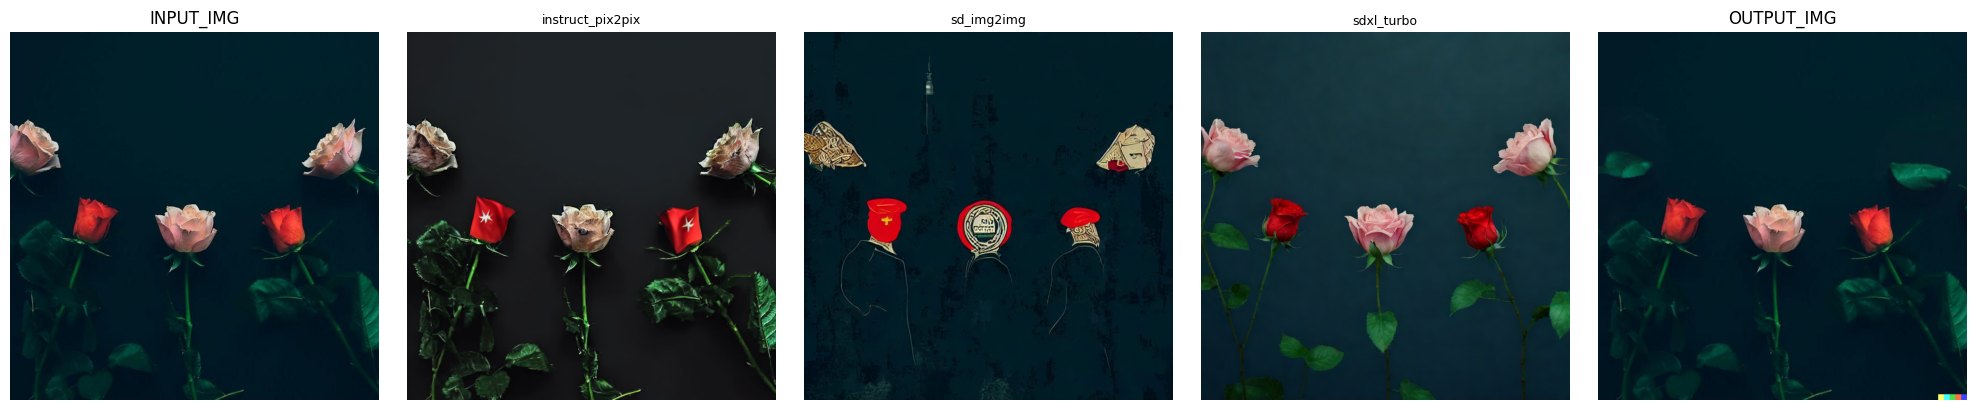

--------------------
Пример 1
Инструкция: Изменить цвет лепестков на фиолетовый
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Модель загружена: timbrooks/instruct-pix2pix


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


100%|██████████| 22/22 [00:09<00:00,  2.25it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Модель загружена: stabilityai/sdxl-turbo


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


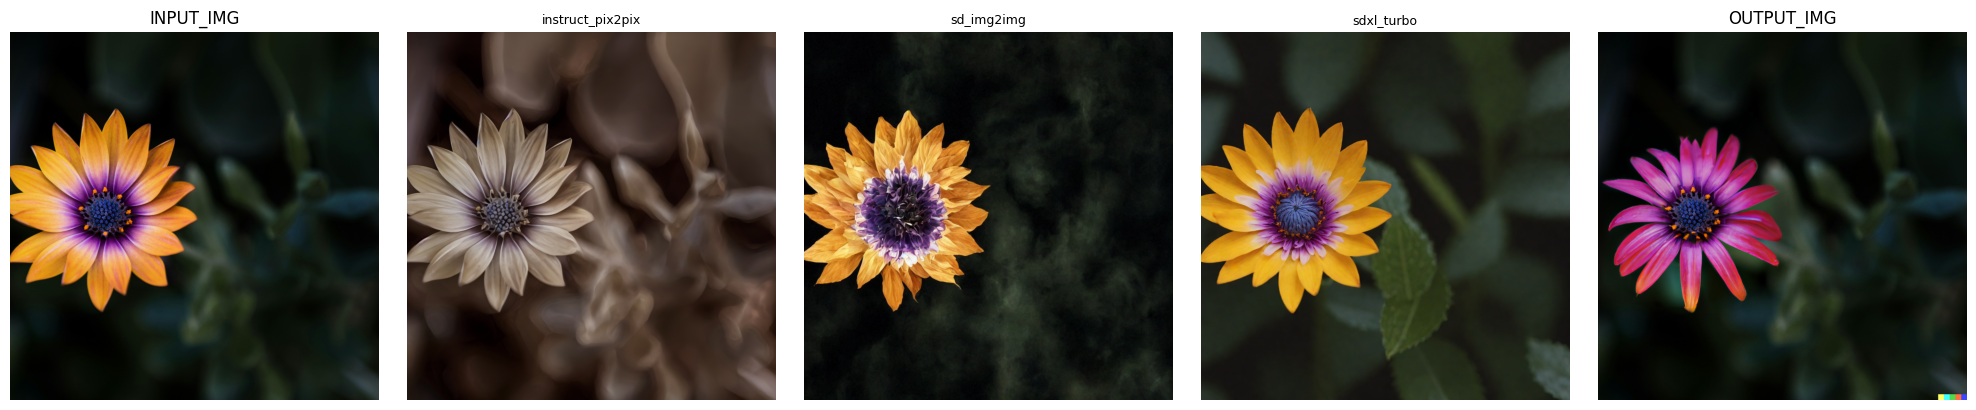

--------------------
Пример 2
Инструкция: Приготовь чашечку.
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Модель загружена: timbrooks/instruct-pix2pix


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


100%|██████████| 22/22 [00:09<00:00,  2.25it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.31it/s]


Модель загружена: stabilityai/sdxl-turbo


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


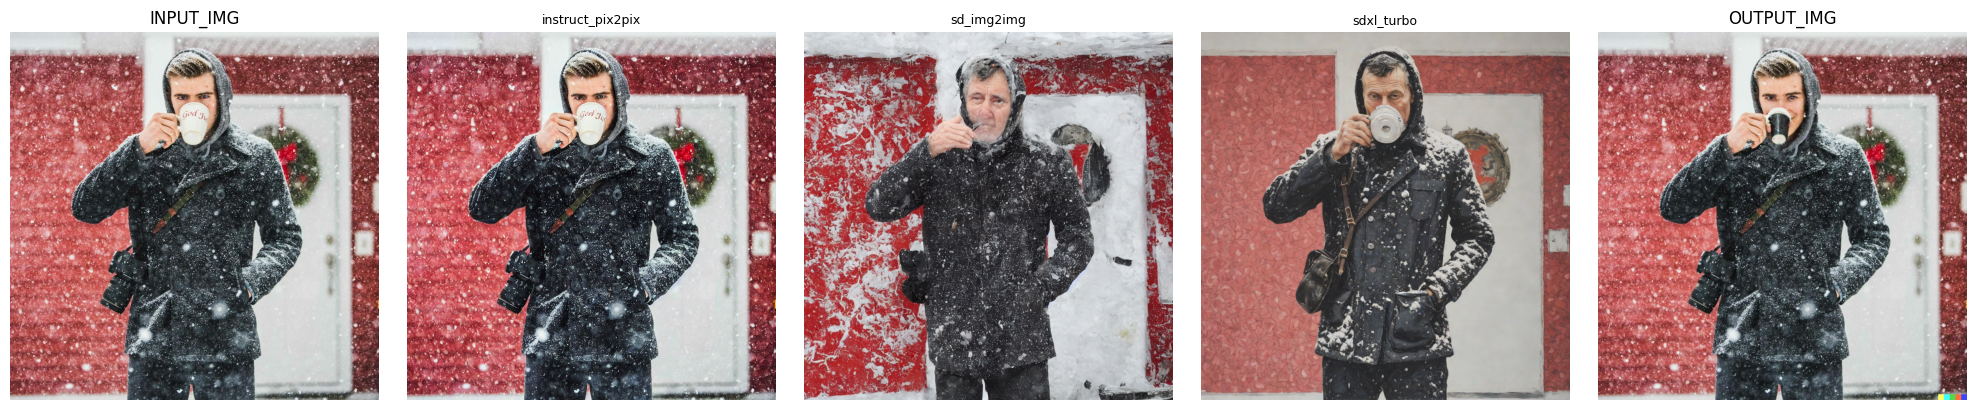

--------------------
Пример 3
Инструкция: Убрать фонарь, висящий из книги
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Модель загружена: timbrooks/instruct-pix2pix


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


100%|██████████| 22/22 [00:09<00:00,  2.25it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Модель загружена: stabilityai/sdxl-turbo


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


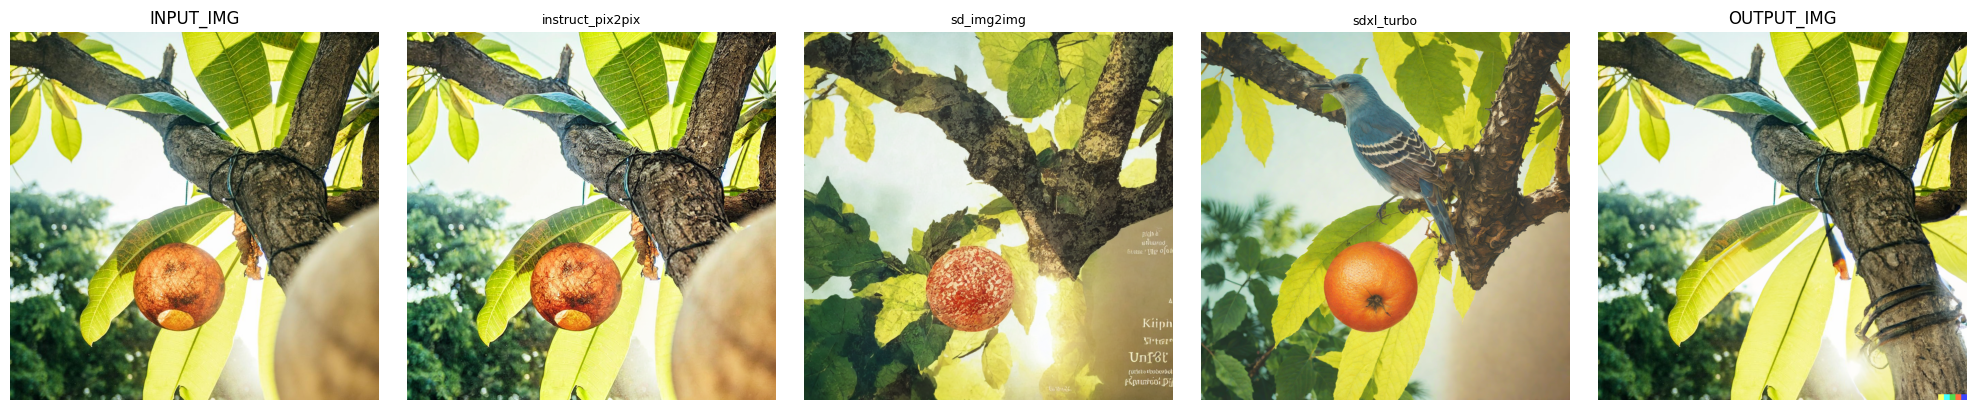

--------------------
Пример 4
Инструкция: Убери листья.
Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


Модель загружена: timbrooks/instruct-pix2pix


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5


100%|██████████| 22/22 [00:09<00:00,  2.25it/s]


Инициализация DiffusionImageEditor


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s]


Модель загружена: stabilityai/sdxl-turbo


100%|██████████| 2/2 [00:00<00:00,  7.19it/s]


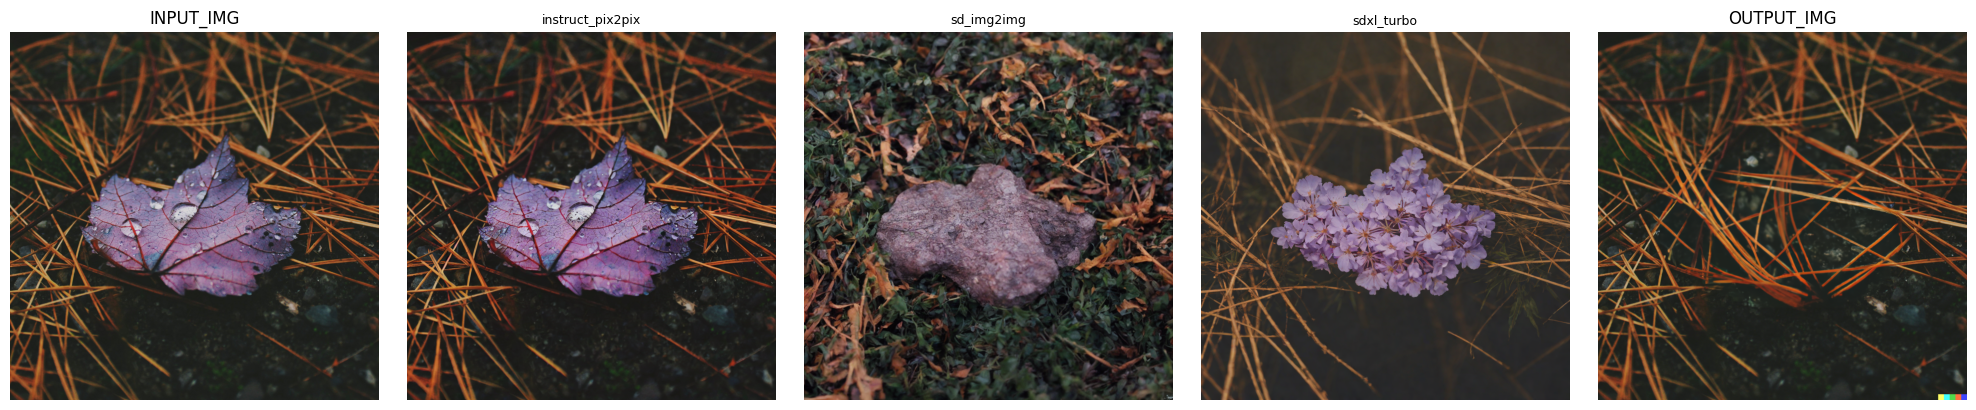

In [10]:
NUM_VIS = min(5, len(subset))
vis_indices = list(range(NUM_VIS))
res_gen = {}
for local_idx in vis_indices:
    sample = subset[local_idx]
    src_img, tgt_img, instr = sample["INPUT_IMG"], sample["OUTPUT_IMG"], sample["EDITING_INSTRUCTION_RU"]

    print(f"{'-' * 20}\nПример {local_idx}\nИнструкция: {instr}")

    generated = {}
    for cfg in MODEL_CONFIGS:
        model_name = cfg["name"]
        model = load_model(cfg)
        try:
            gen_img = model.edit(src_img, instr)
            generated[model_name] = gen_img
            res_gen[f"{model_name}_{local_idx}"] = gen_img
        except Exception as e:
            print(f"  Ошибка генерации для {model_name}: {e}")
        finally:
            model.close()

    n_cols = 2 + len(MODEL_CONFIGS)  # input + models + target
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))

    axes[0].imshow(src_img)
    axes[0].set_title("INPUT_IMG")
    axes[0].axis("off")

    col_idx = 1
    for cfg in MODEL_CONFIGS:
        model_name = cfg["name"]
        ax = axes[col_idx]
        img = generated.get(model_name)
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "error", ha="center", va="center")
        ax.set_title(model_name, fontsize=9)
        ax.axis("off")
        col_idx += 1

    axes[-1].imshow(tgt_img)
    axes[-1].set_title("OUTPUT_IMG")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


### Итого:
 - Модели получились не очень хорошими
 - Уйду на вторую иттерацию по улучшению качества